In [43]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [44]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [45]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


In [46]:
train, test = train_test_split(ratings, test_size = 0.2)

In [47]:
number_user = len(ratings['user_wisata'].unique())
number_destination = len(ratings['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [48]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [50]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =25,
                    callbacks=[early_stopping],)

Epoch 1/25
250/250 [==============================] - 2s 4ms/step - loss: 11.3604 - val_loss: 11.3359
Epoch 2/25
250/250 [==============================] - 1s 3ms/step - loss: 11.3313 - val_loss: 11.2969
Epoch 3/25
250/250 [==============================] - 1s 3ms/step - loss: 11.2789 - val_loss: 11.2175
Epoch 4/25
250/250 [==============================] - 1s 3ms/step - loss: 11.1560 - val_loss: 11.0227
Epoch 5/25
250/250 [==============================] - 1s 3ms/step - loss: 10.8589 - val_loss: 10.5739
Epoch 6/25
250/250 [==============================] - 1s 3ms/step - loss: 10.2343 - val_loss: 9.7295
Epoch 7/25
250/250 [==============================] - 1s 3ms/step - loss: 9.1927 - val_loss: 8.4738
Epoch 8/25
250/250 [==============================] - 1s 3ms/step - loss: 7.7939 - val_loss: 6.9571
Epoch 9/25
250/250 [==============================] - 1s 3ms/step - loss: 6.2659 - val_loss: 5.4308
Epoch 10/25
250/250 [==============================] - 1s 3ms/step - loss: 4.8661 - val_l

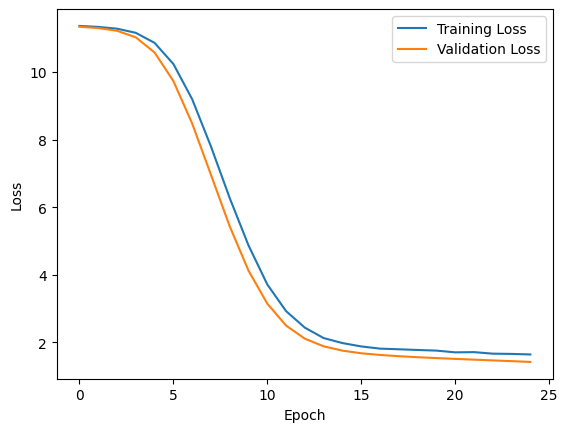

In [56]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [57]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, np_val, user_location = '', ):
    # detail user : digunakan untuk menyimpan data detail user untuk mengerucutkan data yang akan di outputkan
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)
    
    if user_location != '':
        destination = destination[destination['city'] == user_location]
    
    dataFinal = destination[:np_val]
    
    return dataFinal[['name_wisata', 'city', 'destination_photo','description_wisata']].to_dict(orient='records')

## Model result

In [61]:
user_location = 'Bandung'

In [62]:
final_result = collaborative_rec(34, destination, model, 5, user_location = user_location)
final_result

[{'name_wisata': 'Dago Dreampark',
  'city': 'Bandung',
  'destination_photo': 'lala.png',
  'description_wisata': 'Dago Dreampark merupakan wisata kekinian di Kota Bandung dengan luas 13 hektar yang mengusung konsep Jawa - Sunda & Bali dengan dilengkapi berbagai fasilitas & wahana yang menarik.'},
 {'name_wisata': 'Teras Cikapundung BBWS',
  'city': 'Bandung',
  'destination_photo': 'lala.png',
  'description_wisata': 'Teras Cikapundung Bandung sebelumnya merupakan daerah yang kumuh dan tak terurus yang berhasil diubah menjadi tempat wisata. Cikapundung adalah sungai yang membelah Kota Bandung yang dimulai dari daerah Bandung Utara dan bermuara di Sungai Citarum, Bandun'},
 {'name_wisata': 'Curug Batu Templek',
  'city': 'Bandung',
  'destination_photo': 'lala.png',
  'description_wisata': 'Curug Batu Templek Bandung adalah sebuah wisata alam air terjun yang terletak di Kota Bandung Timur. Dari sekian banyak wisata alam air terjun di Bandung, Curug Batu Templek tak kalah menarik karen